In [6]:
# General imports

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import zarr

from gaussian_npe import utils
from gaussian_npe.gaussian_npe_network_disco_dj_CG_Chebyshev_Qx_tests2_2unets_masked import Gaussian_NPE_Network

from datetime import datetime
current_time = datetime.now().strftime("%y%m%d_%H%M%S")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
########## BOX PARAMETERS ##########

box_params = {
        'box_size': 1000.,       #Mpc/h
        'grid_res': 64,         #resolution
        'h': 0.6711,
        'dim': 3
        }

# box = utils.Power_Spectrum_Sampler(box_parameters, device = 'cpu')

########## COSMO PARAMETERS ##########

cosmo_params = {
        'h': 0.6711,
        'Omega_b': 0.049,
        'Omega_cdm': 0.2685,
        # 'A_s': 2.1413e-09,
        'n_s': 0.9624,
        'non linear': 'halofit',
        'sigma8': 0.834,
    }

# Approximate analytical formula for the growth factor from Eisenstein-Hu (see formula A4 in arXiv:9709112)

def growth_D_approx(z, params):
    Om0_m = params['Omega_cdm'] + params['Omega_b']
    Om0_L = 1. - Om0_m
    Om_m = Om0_m * (1.+z)**3 / (Om0_L + Om0_m * (1.+z)**3)
    Om_L = Om0_L/(Om0_L+Om0_m*(1.+z)**3)
    return ((1.+z)**(-1)) * (5. * Om_m/2.) / (Om_m**(4./7.) - Om_L + (1.+Om_m/2.)*(1.+Om_L/70.))

z_Quijote = 127
Dz127_approx = growth_D_approx(z_Quijote, cosmo_params)/growth_D_approx(0, cosmo_params)
print('Dz127_approx =', Dz127_approx)

Dz127_approx = 0.009908314998484411


### Prior

In [3]:
box = utils.Power_Spectrum_Sampler(box_params, device = device)
prior = box.get_prior_Q_factors(lambda k: torch.tensor(utils.get_pk_class(cosmo_params, 0, np.array(k)), device = device))

/scratch-local/osavchenko.15419482/ipykernel_138142/1106551932.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  prior = box.get_prior_Q_factors(lambda k: torch.tensor(utils.get_pk_class(cosmo_params, 0, np.array(k)), device = device))


### Sampling the trained model

In [14]:
def path_to_file_z0(i):
    return f'/gpfs/scratch1/shared/osavchenko/zarr_stores/Quijote_fiducial_64/{i}/df_m_64_PCS_z=0.npy'

def path_to_file_z127(i):
    return f'/gpfs/scratch1/shared/osavchenko/zarr_stores/Quijote_fiducial_64/{i}/df_m_64_PCS_z=127.npy'

sigma_noise = 0.1

mask = torch.tensor(utils.create_cone_mask(fov_angle=[53.13], res=box_params['grid_res']), device='cuda')
delta_fin = torch.from_numpy(np.load(path_to_file_z0(0)).astype('f')).cuda()
delta_fin = delta_fin * mask  + torch.randn_like(delta_fin) * sigma_noise
delta_ic = torch.from_numpy(np.load(path_to_file_z127(0)).astype('f')).cuda() / Dz127_approx
# delta_ic *= mask

sample_obs = {
    'delta_obs': delta_fin.cpu().numpy(),
    'delta_fin': delta_fin.cpu().numpy(),
    'delta_ic': delta_ic.cpu().numpy(),
}
observations = {
    "delta_fin": delta_fin,
}

In [11]:
delta_fin.shape

torch.Size([64, 64, 64])

In [11]:
model = Gaussian_NPE_Network(box, prior, rescaling_factor=Dz127_approx, k_cut=0.03).to(device)
model.load_state_dict(torch.load('plots/251016_222239_Quijote_Chebyshev_30ep_2ksims_lr_5e-3_Qx_2unets_masked/best_model_251016_222239_Quijote_Chebyshev_30ep_2ksims_lr_5e-3_Qx_2unets_masked.pt'))
model.eval()

Gaussian_NPE_Network(
  (unet_mu): UNet(
    (conv_l0): ConvBlock(
      (convs): Sequential(
        (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.01)
        (2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (3): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.01)
      )
    )
    (down_l0): ConvBlock(
      (convs): Sequential(
        (0): Conv3d(8, 8, kernel_size=(2, 2, 2), stride=(2, 2, 2))
        (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (conv_l1): ConvBlock(
      (convs): Sequential(
        (0): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1))
        (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Conv3d(8, 8, kernel_size=(3, 3, 3), str

Sample absolute standard deviation from the truth: 10^3 * std(delta_ic - sample) = 0.5003081


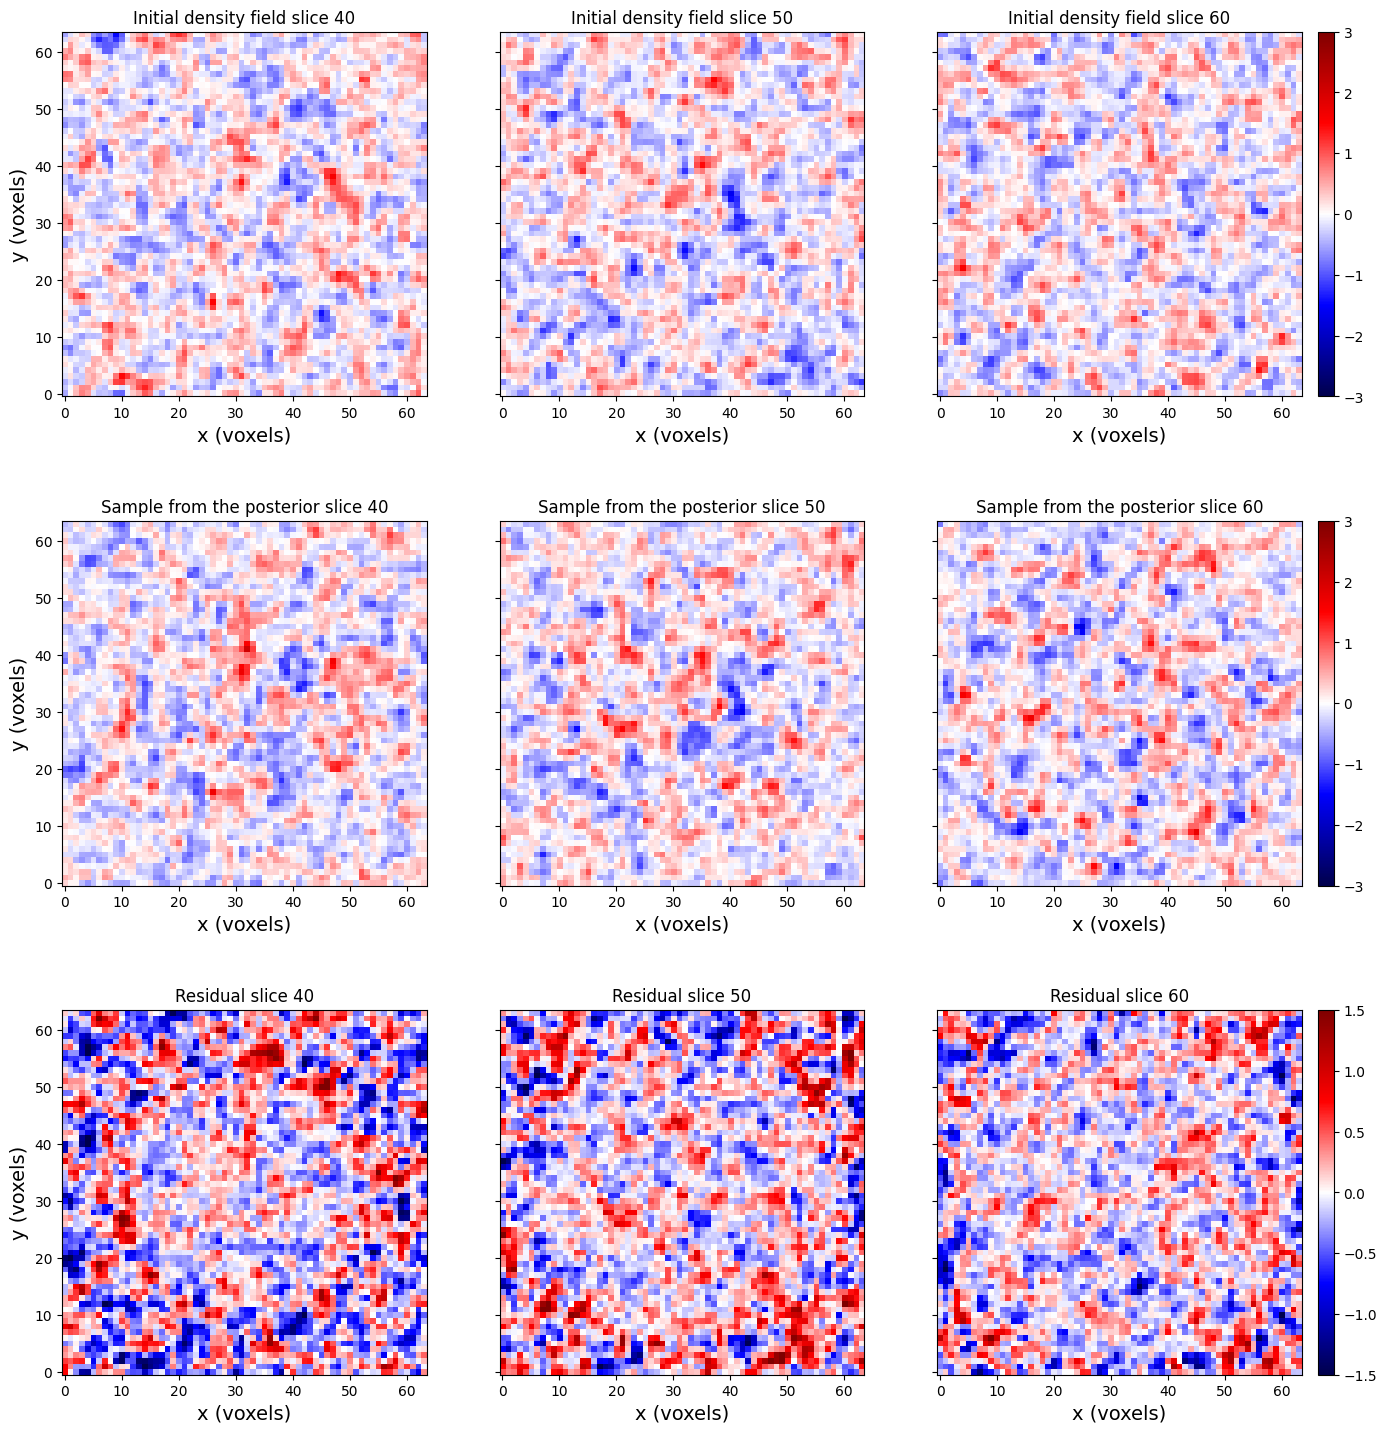

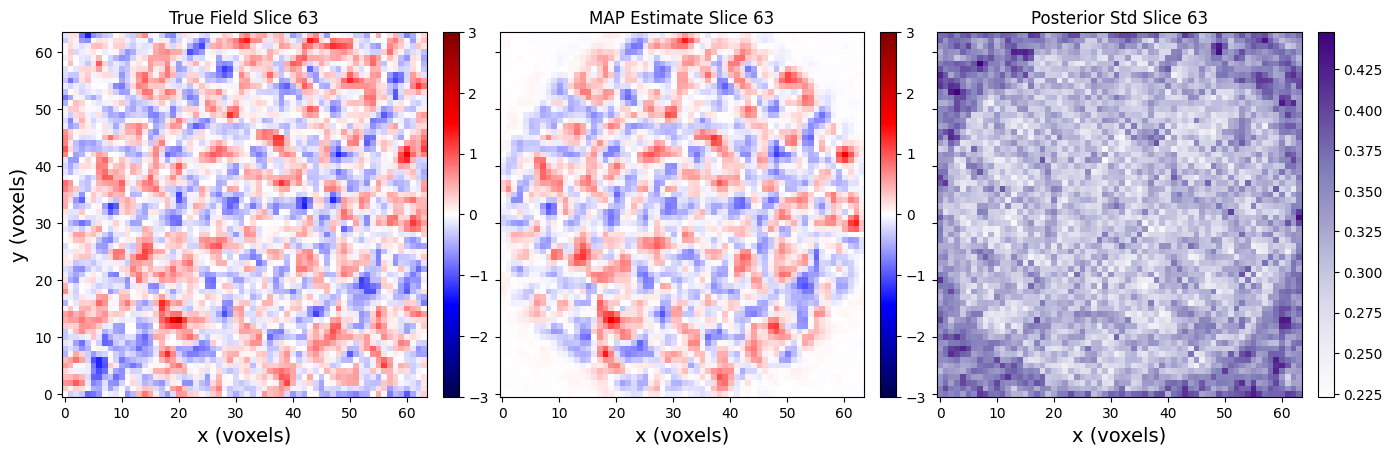


Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.02 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.02 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.02 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time taken = 0.01 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.01
Time t

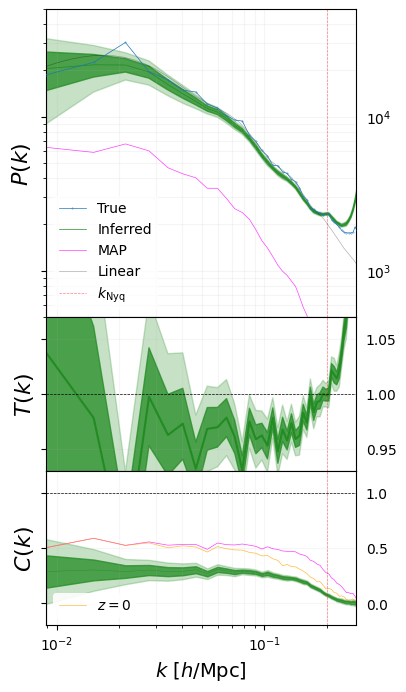

In [15]:
samples = model.sample(num_samples = 100, x_obs = delta_fin, dt=1e-4, steps = 10_000)
z_MAP = model.get_z_MAP(delta_fin)
# samples = z_MAP.unsqueeze(0)

run_name = 'Quijote_OU_sampling_Qx_2unets_masked'
utils.plot_samples_analysis(sample_obs, samples, z_MAP, box_params, cosmo_params, time=current_time, run_name=run_name, MAS='PCS')

In [10]:
samples.shape

torch.Size([1000, 64, 64, 64])

In [11]:
plt.figure()
plt.title(r'Q matrix diagonal values as a function of k, $Q_{like} = U^T D \, U$')
plt.xlabel(r'$k~[h{\rm Mpc}^{-1}]$')
plt.ylabel(r'$D(k)$')

K = box.get_k().cpu().numpy().flatten()

k_Nq = model.box.k_Nq
# K = get_k().flatten()
mask = (K < k_Nq) * (K > 1e-3)
print(mask.sum())
plt.scatter(K[mask][::100], model.Q_like.D.detach().flatten().cpu().numpy()[mask][::100], s=1, label=r'$D_{like}$')
plt.scatter(K[mask][::100], model.Q_prior.D.detach().flatten().cpu().numpy()[mask][::100], s=1, label=r'$D_{prior}$')
plt.scatter(K[mask][::1], model.Q_like.D.detach().flatten().cpu().numpy()[mask][::1] + model.Q_prior.D.detach().cpu().numpy()[mask][::1], s=1, label=r'$D_{posterior}$', alpha=0.5)
plt.axvline(x = k_Nq, color='r', linestyle='--', label='$k_{Nyq}$')

plt.legend(loc='best')
plt.xscale('log')
plt.savefig("./plots/"+current_time+"_"+run_name+"/Q_FFT_matrix_"+current_time+"_"+run_name+".png")
plt.show()
# plt.ylim([5e-3, k_Nq])
# plt.yscale('log')
plt.ylim([0, 100])

137059


(0.0, 100.0)

### Animation

In [16]:
from matplotlib.animation import FuncAnimation

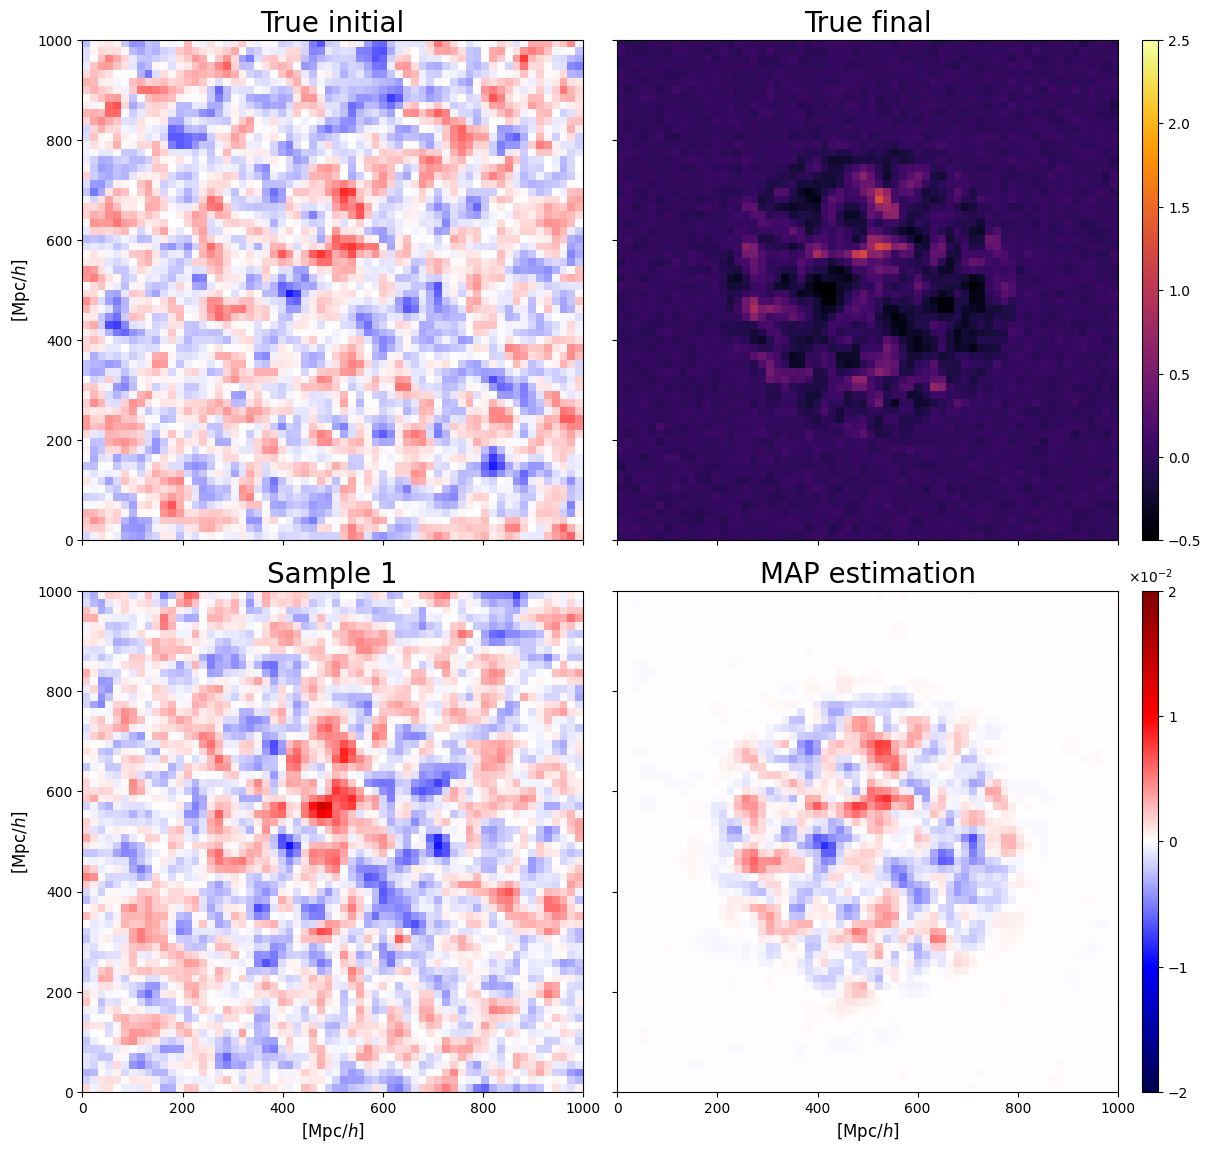

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

extent=[0, 1000, 0, 1000]
vmin1, vmax1 = -2, 2
vmin2, vmax2 = -0.5, 2.5


fig, axes = plt.subplots(2, 2,  figsize=(12, 12), sharex=True, sharey=True, layout='compressed')

figure = axes[0, 0].imshow(sample_obs['delta_ic'][-4:].mean(0), origin='lower', cmap='seismic', vmin=vmin1, vmax=vmax1, extent=extent)
axes[0, 0].set_title(r'True initial', fontsize=20)
axes[0, 0].set_ylabel(r'$[{\rm Mpc} / h]$', fontsize=12)

figure = axes[0, 1].imshow(sample_obs['delta_fin'][-4:].mean(0), origin='lower', cmap='inferno', vmin=vmin2, vmax=vmax2, extent=extent)
axes[0, 1].set_title(r'True final', fontsize=20)
plt.colorbar(figure, ax=axes[0, :], pad = 0.006, aspect=30)#, cax=cbar_ax1)

figure = axes[1, 1].imshow(z_MAP.cpu().numpy()[-4:].mean(0), origin='lower', cmap='seismic', vmin=vmin1, vmax=vmax1, extent=extent)
axes[1, 1].set_title(r'MAP estimation', fontsize=20)
axes[1, 1].set_xlabel(r'$[{\rm Mpc} / h]$', fontsize=12)
clb = plt.colorbar(figure, ax=axes[1, :], pad=0.006, aspect=30, ticks=[-2, -1, 0, 1, 2])
clb.ax.set_title(r'$\times 10^{-2}$', fontsize=10)

# Function to update the plot for each frame
def update(frame):
    axes[1, 0].cla()
    figure = axes[1, 0].imshow(samples.cpu().numpy().astype('f')[frame][-4:].mean(0), origin='lower', cmap='seismic', vmin=vmin1, vmax=vmax1, extent=extent)
    axes[1, 0].set_title(r'Sample ' + str(frame + 1), fontsize=20)
    axes[1, 0].set_xlabel(r'$[{\rm Mpc} / h]$', fontsize=12)
    axes[1, 0].set_ylabel(r'$[{\rm Mpc} / h]$', fontsize=12)

# plt.tight_layout()

# Create the animation
animation = FuncAnimation(fig, update, frames=10, interval=200)

# Save the animation as a GIF file
animation.save('./plots/'+current_time+'_'+run_name+'/animation'+'_'+current_time+'_'+run_name+'.gif', writer='pillow')

# Show the animation (if you want to display it in a Jupyter notebook or similar)
# plt.show()

### Paper plots

In [23]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['cmr10']})

In [ ]:
def plot_samples_analysis(sample_obs, samples, z_MAP, box_params, cosmo_params, MAS=None, run_name='', time=''):
    """
    Plot the samples and their analysis.
    """
    os.makedirs("./plots/"+time+"_"+run_name, exist_ok=True)

    plt.rcParams['figure.facecolor'] = 'white'

    std = samples.std(axis=0)
    std = std.cpu().numpy().astype('f')
    # z_MAP = samples.mean(axis=0)
    z_MAP = z_MAP.cpu().numpy().astype('f')
    
    samples = samples.cpu().numpy().astype('f')
    sample = samples[0]
    delta_ic = sample_obs['delta_ic'].astype('f')#.cpu().numpy()
    # delta_fin = sample_obs['delta_fin'].astype('f')#.cpu().numpy()
    delta_fin = sample_obs['delta_obs'].astype('f')#.cpu().numpy()
    residual = sample - delta_ic
    print('Sample absolute standard deviation from the truth: 10^3 * std(delta_ic - sample) =', residual.std())

    fig, axes = plt.subplots(3, 3, figsize = (16, 18), sharey=True)
    vmin, vmax = -3, 3
    for i in range(3):
        s=40+10*i
        figure = axes[0,i].imshow(delta_ic[s], origin='lower', cmap='seismic', vmin=vmin, vmax=vmax)#, interpolation = 'bilinear')#, interpolation='gaussian')
        axes[0,i].set_title(f'Initial density field slice {s}')
        axes[0,i].set_xlabel('x (voxels)',fontsize=14)
        if i == 0:
            axes[0,i].set_ylabel('y (voxels)',fontsize=14)
        if i == 2:
            cbar_ax1 = fig.add_axes([axes[0, i].get_position().x1 + 0.01, axes[0, i].get_position().y0, 0.01, axes[0, i].get_position().height])
            plt.colorbar(figure, ax=axes[0, :], cax=cbar_ax1)
        
        
        figure = axes[1,i].imshow(sample[s], origin='lower', cmap='seismic', vmin=vmin, vmax=vmax)#, interpolation = 'bilinear')#, interpolation='gaussian')
        axes[1,i].set_title(f'Sample from the posterior slice {s}')
        axes[1,i].set_xlabel('x (voxels)',fontsize=14)
        if i == 0:
            axes[1,i].set_ylabel('y (voxels)',fontsize=14)
        if i == 2:
            cbar_ax1 = fig.add_axes([axes[1, i].get_position().x1 + 0.01, axes[1, i].get_position().y0, 0.01, axes[1, i].get_position().height])
            plt.colorbar(figure, ax=axes[1, :], cax=cbar_ax1)


        figure = axes[2,i].imshow(residual[s], origin='lower', cmap='seismic', vmin=vmin/2, vmax=vmax/2)#, interpolation='gaussian')
        axes[2,i].set_title(f'Residual slice {s}')
        axes[2,i].set_xlabel('x (voxels)',fontsize=14)
        if i == 0:
            axes[2,i].set_ylabel('y (voxels)',fontsize=14)
        if i == 2:
            cbar_ax1 = fig.add_axes([axes[2, i].get_position().x1 + 0.01, axes[2, i].get_position().y0, 0.01, axes[2, i].get_position().height])
            plt.colorbar(figure, ax=axes[2, :], cax=cbar_ax1)
    fig.savefig("./plots/"+time+"_"+run_name+"/samples_"+time+"_"+run_name+".png")


    fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharey=True)
    slice_idx = 63  # You can adjust this index
    vmin, vmax = -3, 3

    # Plot 1: True Field (delta_ic)
    im0 = axes[0].imshow(delta_ic[slice_idx], origin='lower', cmap='seismic', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'True Field Slice {slice_idx}')
    axes[0].set_xlabel('x (voxels)', fontsize=14)
    axes[0].set_ylabel('y (voxels)', fontsize=14)
    cbar_ax0 = fig.add_axes([axes[0].get_position().x1 + 0.01, axes[0].get_position().y0, 0.01, axes[0].get_position().height])
    plt.colorbar(im0, cax=cbar_ax0)

    # Plot 2: MAP Field (z_MAP)
    im1 = axes[1].imshow(z_MAP[slice_idx], origin='lower', cmap='seismic', vmin=vmin, vmax=vmax)
    axes[1].set_title(f'MAP Estimate Slice {slice_idx}')
    axes[1].set_xlabel('x (voxels)', fontsize=14)
    cbar_ax1 = fig.add_axes([axes[1].get_position().x1 + 0.01, axes[1].get_position().y0, 0.01, axes[1].get_position().height])
    plt.colorbar(im1, cax=cbar_ax1)

    # Plot 3: Standard Deviation (std)
    # std_vmax = std[slice_idx].max()  # or set a fixed value like 1.0
    im2 = axes[2].imshow(std[slice_idx], origin='lower', cmap='Purples')#, vmin=0, vmax=std_vmax)
    axes[2].set_title(f'Posterior Std Slice {slice_idx}')
    axes[2].set_xlabel('x (voxels)', fontsize=14)
    cbar_ax2 = fig.add_axes([axes[2].get_position().x1 + 0.01, axes[2].get_position().y0, 0.01, axes[2].get_position().height])
    plt.colorbar(im2, cax=cbar_ax2)

    # plt.tight_layout()
    fig.savefig("./plots/"+time+"_"+run_name+"/std_"+time+"_"+run_name+".png")
    plt.show()

    box = Power_Spectrum_Sampler(box_params, device = 'cpu')

    # Calculating power spectra, transfer functions and cross-power spectra for the true field, MAP estimation and linear prediction
    k_min, k_max = 1e-4, 10  # h/Mpc
    k_lin = np.logspace(np.log10(k_min), np.log10(k_max), 100)
    pk_class_z0 = get_pk_class(cosmo_params, 0, k_lin)

    k_pylians, pk_pylians_ic = box.get_pk_pylians(delta_ic, MAS=MAS)

    # MAP = z_MAP.cpu().numpy().astype('f')
    k_pylians, pk_pylians_MAP = box.get_pk_pylians(z_MAP, MAS=MAS)
    tk_pylians_MAP = np.sqrt(pk_pylians_MAP/pk_pylians_ic)

    Pk = PKL.XPk([z_MAP, delta_ic], box_params['box_size'], axis=0, MAS=[MAS, MAS], threads=1)
    Pk0_1  = Pk.Pk[:,0,0]
    Pk0_2  = Pk.Pk[:,0,1]
    Pk0_X  = Pk.XPk[:,0,0]

    xpk_pylians_MAP = Pk0_X / (Pk0_1 * Pk0_2)**0.5


    Pk = PKL.XPk([delta_ic, delta_fin], box_params['box_size'], axis=0, MAS=[MAS, MAS], threads=1)
    Pk0_1  = Pk.Pk[:,0,0]
    Pk0_2  = Pk.Pk[:,0,1]
    Pk0_X  = Pk.XPk[:,0,0]

    xpk_pylians_linear = Pk0_X / (Pk0_1 * Pk0_2)**0.5


    # Calculating power spectra, transfer functions and cross-power spectra for samples
    pks = []
    tks = []
    xpks = []

    for i in range(len(samples)):
        delta_ic_samples = samples[i]#.astype('float32')

        k_pylians, pk_pylians_draws = box.get_pk_pylians(delta_ic_samples, MAS=MAS)
        Pk = PKL.XPk([delta_ic_samples, delta_ic], box_params['box_size'], axis=0, MAS=[MAS, MAS], threads=1)
        Pk0_1  = Pk.Pk[:, 0, 0]
        Pk0_2  = Pk.Pk[:, 0, 1]
        Pk0_X  = Pk.XPk[:, 0, 0]

        pks.append(pk_pylians_draws)
        tks.append(np.sqrt(pk_pylians_draws/pk_pylians_ic))
        xpks.append(Pk0_X / (Pk0_1 * Pk0_2)**0.5)

    pks = np.array(pks)
    tks = np.array(tks)
    xpks = np.array(xpks)

    k_Nq = box.k_Nq

    fig, axs = plt.subplots(3, sharex=True, sharey=False, height_ratios=[2, 1, 1])#, layout='compressed')
    # Plot power spectra of truth vs generated samples
    h = 4
    w = 4
    fig.set_size_inches((w, h*2))
    axs[0].plot(k_pylians, pk_pylians_ic, marker='.', markersize=0.5, label=r'True', linewidth=0.5, zorder=1e6)
    axs[0].plot(k_pylians, pks.mean(0), label=r'Inferred', linewidth=0.5, color='forestgreen')
    axs[0].fill_between(k_pylians, pks.mean(0) - pks.std(0), pks.mean(0) + pks.std(0), alpha=0.75, color='forestgreen')#color='#82A8D1')
    axs[0].fill_between(k_pylians, pks.mean(0) - 2*pks.std(0), pks.mean(0) + 2*pks.std(0), alpha=0.25, color='forestgreen')#color='#82A8D1')
    axs[0].plot(k_pylians, pk_pylians_MAP, color='magenta', label=r'MAP', alpha=0.75, linewidth=0.5)
    axs[0].plot(k_lin, pk_class_z0, label=r'Linear', color='black', alpha=0.3, linewidth=0.5)
    axs[0].axvline(x = k_Nq, color='r', linestyle='--', label=r'$k_{\rm{Nyq}}$', linewidth=0.5, alpha=0.5)
    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    # axs[0].tick_params(axis='x', which='both', length=0)
    # axs[0].tick_params(axis='x', which='both', length=1)
    axs[0].set_ylabel(r"$P(k)$", fontsize=16)
    axs[0].legend(facecolor='white', edgecolor='none', framealpha=0.8)
    axs[0].set_ylim([5e2, 5e4])
    axs[0].set_xlim(left=k_pylians[0], right=k_Nq + 0.075)#1.1*k_pylians[-1])
    axs[0].grid(which='both', alpha=0.125)
    axs[0].yaxis.set_tick_params(labelright=True, labelleft=False)

    # Plot transfer function of sample
    axs[1].plot(k_pylians, tks.mean(0), color='forestgreen')#'#82A8D1')
    axs[1].fill_between(k_pylians, tks.mean(0) - tks.std(0), tks.mean(0) + tks.std(0), alpha=0.75, color='forestgreen')#'#82A8D1')
    axs[1].fill_between(k_pylians, tks.mean(0) - 2*tks.std(0), tks.mean(0) + 2*tks.std(0), alpha=0.25, color='forestgreen')#'#82A8D1')
    axs[1].plot(k_pylians, tk_pylians_MAP, color='magenta', alpha=0.75, linewidth=0.5)
    axs[1].axvline(x = k_Nq, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
    axs[1].axhline(1.0, color='k', ls='--', lw=0.5)
    axs[1].set_xscale('log')
    axs[1].set_ylabel(r"$T(k)$", fontsize=16)
    # axs[1].tick_params(axis='x', which='both', length=1)
    axs[1].set_ylim(bottom=0.95, top=1.1)
    axs[1].set_ylim(0.93, 1.07)
    axs[1].set_xlim(left=k_pylians[0])
    axs[1].grid(which='both', alpha=0.1)
    # axs[1].legend(facecolor='white', edgecolor='none', framealpha=0.8)
    axs[1].set_yticks([0.95, 1, 1.05])
    axs[1].yaxis.set_tick_params(labelright=True, labelleft=False)

    # Plot cross-correlation of true vs samples
    axs[2].plot(k_pylians, xpk_pylians_MAP, color='magenta', alpha=0.75, linewidth=0.5)
    axs[2].plot(k_pylians, xpk_pylians_linear, alpha=0.75, linewidth=0.5, color='orange', label=r'$z=0$')
    axs[2].plot(k_pylians, xpks.mean(0), color='forestgreen', linewidth=0.25)#color='#82A8D1')
    axs[2].fill_between(k_pylians, xpks.mean(0) + xpks.std(0), xpks.mean(0) - xpks.std(0), alpha=0.75, color='forestgreen')#color='#82A8D1')
    axs[2].fill_between(k_pylians, xpks.mean(0) + 2*xpks.std(0), xpks.mean(0) - 2*xpks.std(0), alpha=0.25, color='forestgreen')#color='#82A8D1')
    axs[2].axvline(x = k_Nq, color='r', linestyle='--', linewidth=0.5, alpha=0.5)
    axs[2].axhline(1.0, color='k', ls='--', lw=0.5)
    # axs[2].axhline(0, color='k', alpha=0.1, linewidth=0.75)#, linestyle='--')
    axs[2].set_xscale('log')
    # axs[2].tick_params(axis='x', which='both', length=1)
    # axs[2].tick_params(axis='x', which='both', length=0)
    axs[2].set_ylabel(r"$C(k)$", fontsize=16)
    axs[2].set_xlabel(r"$k$ [$h / \rm{Mpc}$]", fontsize=14)
    axs[2].set_ylim([-0.2, 1.2])
    axs[2].grid(which='both', alpha=0.1)
    axs[2].legend(facecolor='white', edgecolor='none', framealpha=0.9, loc="lower left")
    axs[2].set_yticks([0, 0.5, 1])
    axs[2].yaxis.set_tick_params(labelright=True, labelleft=False)

    plt.subplots_adjust(hspace=0)
    fig.savefig("./plots/"+time+"_"+run_name+"/sum_"+time+"_"+run_name+".png")#, bbox_inches='tight')

def plot_Q_matrix(K, network, time='', run_name=''):
    os.makedirs("./plots/"+time+"_"+run_name, exist_ok=True)
    plt.figure()
    plt.title(r'Q matrix diagonal values as a function of k, $Q_{like} = U^T D \, U$')
    plt.xlabel(r'$k~[h{\rm Mpc}^{-1}]$')
    plt.ylabel(r'$D(k)$')

    K = K.cpu().numpy().flatten()

    k_Nq = network.box.k_Nq
    # K = get_k().flatten()
    mask = (K < k_Nq) * (K > 1e-3)
    print(mask.sum())
    plt.scatter(K[mask][::100], network.Q_like.D.detach().flatten().cpu().numpy()[mask][::100], s=1, label=r'$D_{like}$')
    plt.scatter(K[mask][::100], network.Q_prior.D.detach().flatten().cpu().numpy()[mask][::100], s=1, label=r'$D_{prior}$')
    plt.scatter(K[mask][::1], network.Q_like.D.detach().flatten().cpu().numpy()[mask][::1] + network.Q_prior.D.detach().cpu().numpy()[mask][::1], s=1, label=r'$D_{posterior}$', alpha=0.5)
    plt.axvline(x = k_Nq, color='r', linestyle='--', label='$k_{Nyq}$')

    plt.legend(loc='best')
    plt.xscale('log')
    plt.savefig("./plots/"+time+"_"+run_name+"/Q_FFT_matrix_"+time+"_"+run_name+".png")
    plt.show()
    # plt.ylim([5e-3, k_Nq])
    # plt.yscale('log')
    plt.ylim([0, 100])

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (12, 18), sharey=True)
vmin, vmax = -3, 3
for i in range(3):
    s=40+10*i
    figure = axes[0,i].imshow(delta_ic[s], origin='lower', cmap='seismic', vmin=vmin, vmax=vmax)#, interpolation = 'bilinear')#, interpolation='gaussian')
    axes[0,i].set_title(f'Initial density field slice {s}')
    axes[0,i].set_xlabel('x (voxels)',fontsize=14)
    if i == 0:
        axes[0,i].set_ylabel('y (voxels)',fontsize=14)
    if i == 2:
        cbar_ax1 = fig.add_axes([axes[0, i].get_position().x1 + 0.01, axes[0, i].get_position().y0, 0.01, axes[0, i].get_position().height])
        plt.colorbar(figure, ax=axes[0, :], cax=cbar_ax1)
    
    
    figure = axes[1,i].imshow(sample[s], origin='lower', cmap='seismic', vmin=vmin, vmax=vmax)#, interpolation = 'bilinear')#, interpolation='gaussian')
    axes[1,i].set_title(f'Sample from the posterior slice {s}')
    axes[1,i].set_xlabel('x (voxels)',fontsize=14)
    if i == 0:
        axes[1,i].set_ylabel('y (voxels)',fontsize=14)
    if i == 2:
        cbar_ax1 = fig.add_axes([axes[1, i].get_position().x1 + 0.01, axes[1, i].get_position().y0, 0.01, axes[1, i].get_position().height])
        plt.colorbar(figure, ax=axes[1, :], cax=cbar_ax1)

fig.savefig("./plots/"+current_time+"_"+run_name+"/samples_"+current_time+"_"+run_name+".png")

In [24]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# samples = samples.cpu().numpy().astype('f')
draw = samples[0]
delta_target = sample_obs['delta_ic']
MAP = z_MAP.cpu().numpy()
var = samples.var(axis=0)
# residual = draw - delta_target
# print('Draw absolute standard deviation from the truth: 10^3 * std(delta - draw) =', 1e3 * residual.std())

extent=[0, 1000, 0, 1000]
vmin1, vmax1 = -1.5, 1.5
vmin2, vmax2 = -0.5, 2.5
# ticks = np.arange(0, 1001, 100)
# ticklabels = ['0', '', '200', '', '400', '', '600', '', '800', '', '1000']


fig, axes = plt.subplots(2, 3,  figsize=(12, 8), layout='compressed')#, sharex=True, sharey=True,)

figure = axes[0, 0].imshow(sample_obs['delta_ic'][-4:].mean(0), origin='lower', cmap='seismic', vmin=vmin1, vmax=vmax1, extent=extent)
axes[0, 0].set_title(r'True initial', fontsize=22)
axes[0, 0].set_xticklabels([])
axes[0, 0].set_yticklabels([])
# axes[0, 0].set_ylabel(r'$[{\rm Mpc} / h]$', fontsize=14)
# axes[0, 0].set_xticklabels([])
# cbar_ax1 = fig.add_axes([axes[0, 0].get_position().x1 + 0.01, axes[0, 0].get_position().y0, 0.01, axes[0, 0].get_position().height])
# cbar_ax1.set_title(r'$\times 10^{-2}$', fontsize=12)
# plt.colorbar(figure, ax=axes[0, :])#, cax=cbar_ax1, ticks=[-2, -1, 0, 1, 2])

figure = axes[0, 2].imshow(sample_obs['delta_fin'][-4:].mean(0), origin='lower', cmap='inferno', vmin=vmin2, vmax=vmax2, extent=extent)
axes[0, 2].set_title(r'True final', fontsize=22)
# axes[0, 2].set_xlabel(r'$[h \ {\rm Mpc}^{-1}]$', fontsize=12)
# axes[0, 2].set_ylabel(r'$[h \ {\rm Mpc}^{-1}]$', fontsize=12)
axes[0, 2].set_xticklabels([])
axes[0, 2].set_yticklabels([])
# cbar_ax1 = fig.add_axes([axes[0, 1].get_position().x1 + 0.015, axes[0, 1].get_position().y0, 0.01, axes[1, 0].get_position().height])
# plt.colorbar(figure, ax=axes[1, 0], pad = 0.006, aspect=30)#, cax=cbar_ax1)

figure = axes[0, 1].imshow(samples[1][-4:].mean(0), origin='lower', cmap='seismic', vmin=vmin1, vmax=vmax1, extent=extent)
axes[0, 1].set_title(r'Sample 1', fontsize=22)
axes[0, 1].set_xticklabels([])
axes[0, 1].set_yticklabels([])
# axes[0, 1].set_ylabel(r'$[{\rm Mpc} / h]$', fontsize=14)
# axes[0, 1].set_xlabel(r'$[{\rm Mpc} / h]$', fontsize=14)
# clb = plt.colorbar(figure, ax=axes[1, 1], pad=0.006, aspect=30, ticks=[-2, -1, 0, 1, 2])
# clb.ax.set_title(r'$\times 10^{-2}$', fontsize=12)

# axes[1, 1].set_ylabel(r'$[{\rm Mpc} / h]$', fontsize=12)
# figure = axes[1, 1].imshow(1e2 * draws[i][-4:].mean(0), origin='lower', cmap='seismic', vmin=vmin1, vmax=vmax1, extent=extent)
# axes[1, 1].set_title(titles1[i], fontsize=16)
# axes[1, 1].set_xlabel(r'$[{\rm Mpc} / h]$', fontsize=12)
# cbar_ax1 = fig.add_axes([axes[1, 1].get_position().x1 + 0.015, axes[1, 1].get_position().y0, 0.01, axes[1, 1].get_position().height])
# cbar_ax1.set_title(r'$\times 10^{-2}$', fontsize=10)
# plt.colorbar(figure, ax=axes[1, :], cax=cbar_ax1, ticks=[-2, -1, 0, 1, 2])

figure = axes[1, 1].imshow(samples[2][-4:].mean(0), origin='lower', cmap='seismic', vmin=vmin1, vmax=vmax1, extent=extent)
# axes[1, 1].set_title(f'Sample #{frame + 1}', fontsize=16)
axes[1, 1].set_title(r'Sample 2', fontsize=22)
axes[1, 1].set_xticklabels([])
axes[1, 1].set_yticklabels([])
# axes[1, 1].set_yticklabels([])
# axes[1, 1].set_xlabel(r'$[{\rm Mpc} / h]$', fontsize=14)

figure = axes[1, 0].imshow(MAP[-4:].mean(0), origin='lower', cmap='seismic', vmin=vmin1, vmax=vmax1, extent=extent)
axes[1, 0].set_title(r'MAP', fontsize=22)
axes[1, 0].set_xticklabels([])
axes[1, 0].set_yticklabels([])
# axes[0, 1].set_ylabel(r'$[{\rm Mpc} / h]$', fontsize=12)
# axes[0, 1].set_xlabel(r'$[{\rm Mpc} / h]$', fontsize=12)
# axes[0, 2].set_xticklabels([])
# axes[0, 2].set_yticklabels([])
# clb = plt.colorbar(figure, ax=axes[0, 2], pad=0.006, aspect=30, ticks=[-2, -1, 0, 1, 2])
# clb.ax.set_title(r'$\times 10^{-2}$', fontsize=12)

figure = axes[1, 2].imshow(var[-4:].mean(0), origin='lower', cmap='Purples', extent=extent)#, vmin=vmin1, vmax=vmax1, )
axes[1, 2].set_title(r'Variance', fontsize=22)
axes[1, 2].set_xticklabels([])
axes[1, 2].set_yticklabels([])
# axes[0, 1].set_ylabel(r'$[{\rm Mpc} / h]$', fontsize=12)
# axes[0, 1].set_xlabel(r'$[{\rm Mpc} / h]$', fontsize=12)
# axes[1, 2].set_xticklabels([])
# axes[1, 2].set_yticklabels([])
# clb = plt.colorbar(figure, ax=axes[1, 2], pad=0.006, aspect=30, ticks=[-2, -1, 0, 1, 2])
# clb.ax.set_title(r'$\times 10^{-2}$', fontsize=12)


# figure = axes[1, 1].imshow(1e2 * draws[2][-4:].mean(0), origin='lower', cmap='seismic', vmin=vmin1, vmax=vmax1, extent=extent)
# # axes[1, 1].set_title(f'Sample #{frame + 1}', fontsize=16)
# axes[1, 1].set_title(r'Sample 2', fontsize=20)
# axes[1, 1].set_xlabel(r'$[{\rm Mpc} / h]$', fontsize=12)

# K = get_k().flatten()
# # mask = (K.cpu() < k_Nq) * (K.cpu() > 1e-3)
# mask1 = (K.cpu() > 1e-3) * (K.cpu() < 0.03)
# mask2 = (K.cpu() > 0.03) * (K.cpu() < 0.1)
# mask3 = (K.cpu() > 0.1) * (K.cpu() < k_Nq)
# print(mask.sum())



# plt.tight_layout()

fig.savefig("./plots/"+current_time+"_"+run_name+"/samples_"+current_time+"_"+run_name+".pdf")#, bbox_inches='tight')

PANIC: unprotected error in call to Lua API (zlib library version does not match - header: 1.2.11, library: 1.3.1)


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmr17.tfm' in your texmf tree, but could not find it

PANIC: unprotected error in call to Lua API (zlib library version does not match - header: 1.2.11, library: 1.3.1)


Error in callback <function _draw_all_if_interactive at 0x15114487f420> (for post_execute), with arguments args (),kwargs {}:


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmr17.tfm' in your texmf tree, but could not find it

PANIC: unprotected error in call to Lua API (zlib library version does not match - header: 1.2.11, library: 1.3.1)


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmr17.tfm' in your texmf tree, but could not find it

<Figure size 1200x800 with 6 Axes>

In [21]:
var

array([[[0.0089821 , 0.01095707, 0.01174246, ..., 0.0105591 ,
         0.01153392, 0.01345617],
        [0.00973619, 0.0152047 , 0.0143507 , ..., 0.01189783,
         0.01069277, 0.01040417],
        [0.01148788, 0.01196388, 0.0116677 , ..., 0.01088913,
         0.00912444, 0.00941122],
        ...,
        [0.01360222, 0.01179327, 0.01368875, ..., 0.01008467,
         0.00986469, 0.01227067],
        [0.01316541, 0.01080422, 0.01518692, ..., 0.0126335 ,
         0.01098386, 0.00831863],
        [0.01362447, 0.01000623, 0.0105025 , ..., 0.0110945 ,
         0.01028862, 0.01009792]],

       [[0.01233491, 0.01533533, 0.0139504 , ..., 0.01054034,
         0.01221824, 0.01365457],
        [0.01320698, 0.01431713, 0.01416126, ..., 0.0133496 ,
         0.00951249, 0.01135133],
        [0.0108196 , 0.01441632, 0.01150565, ..., 0.01077345,
         0.00791913, 0.00949254],
        ...,
        [0.0104689 , 0.00990923, 0.01298466, ..., 0.0083617 ,
         0.00890932, 0.01172337],
        [0.0